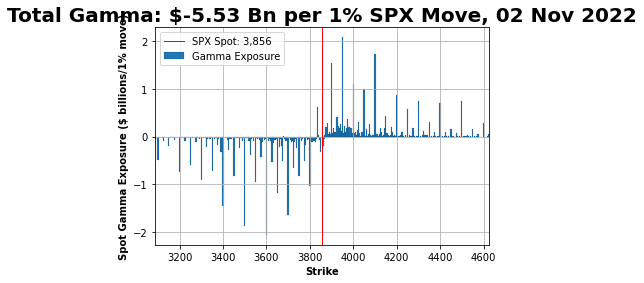

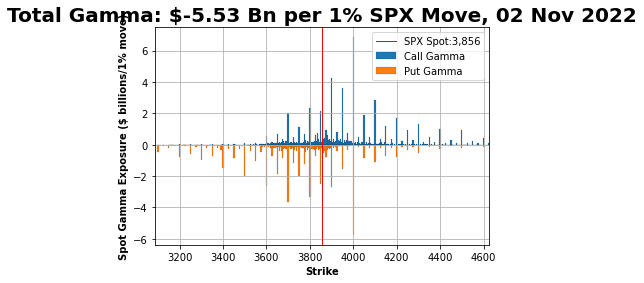

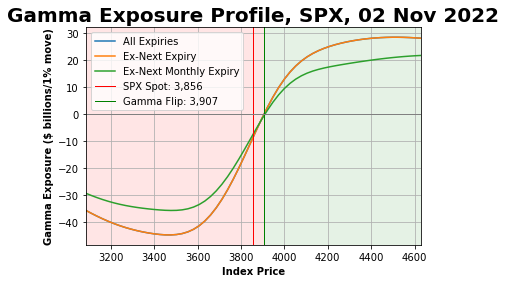

In [4]:
#https://perfiliev.co.uk/market-commentary/how-to-calculate-gamma-exposure-and-zero-gamma-level/
import pandas as pd
import numpy as np
import scipy
from scipy.stats import norm
import matplotlib.pyplot as plt
from datetime import datetime, timedelta, date

pd.options.display.float_format = '{:,.4f}'.format

# Inputs and Parameters
filename = 'spx_quotedata_02112022.csv'

# Black-Scholes European-Options Gamma
def calcGammaEx(S, K, vol, T, r, q, optType, OI):
    if T == 0 or vol == 0:
        return 0

    dp = (np.log(S/K) + (r - q + 0.5*vol**2)*T) / (vol*np.sqrt(T))
    dm = dp - vol*np.sqrt(T) 

    if optType == 'call':
        gamma = np.exp(-q*T) * norm.pdf(dp) / (S * vol * np.sqrt(T))
        return OI * 100 * S * S * 0.01 * gamma 
    else: # Gamma is same for calls and puts. This is just to cross-check
        gamma = K * np.exp(-r*T) * norm.pdf(dm) / (S * S * vol * np.sqrt(T))
        return OI * 100 * S * S * 0.01 * gamma 

def isThirdFriday(d):
    return d.weekday() == 4 and 15 <= d.day <= 21

# This assumes the CBOE file format hasn't been edited, i.e. table beginds at line 4
optionsFile = open(filename)
optionsFileData = optionsFile.readlines()
optionsFile.close()

# Get SPX Spot
spotLine = optionsFileData[1]
spotPrice = 3856
fromStrike = 0.8 * spotPrice
toStrike = 1.2 * spotPrice

# Get Today's Date
dateLine = optionsFileData[2]
todayDate = dateLine.split('Date: ')[1].split(' ')
day1=todayDate[1].split(',')

year=int(todayDate[2])
month=todayDate[0]
day=int(day1[0])

todayDate = datetime.strptime(month,'%B')
todayDate = todayDate.replace(day=day, year=year)

# Get SPX Options Data
df = pd.read_csv(filename, sep=",", header=None, skiprows=4)
df.columns = ['ExpirationDate','Calls','CallLastSale','CallNet','CallBid','CallAsk','CallVol',
              'CallIV','CallDelta','CallGamma','CallOpenInt','StrikePrice','Puts','PutLastSale',
              'PutNet','PutBid','PutAsk','PutVol','PutIV','PutDelta','PutGamma','PutOpenInt']

df['ExpirationDate'] = pd.to_datetime(df['ExpirationDate'], format='%a %b %d %Y')
df['ExpirationDate'] = df['ExpirationDate'] + timedelta(hours=16)
df['StrikePrice'] = df['StrikePrice'].astype(float)
df['CallIV'] = df['CallIV'].astype(float)
df['PutIV'] = df['PutIV'].astype(float)
df['CallGamma'] = df['CallGamma'].astype(float)
df['PutGamma'] = df['PutGamma'].astype(float)
df['CallOpenInt'] = df['CallOpenInt'].astype(float)
df['PutOpenInt'] = df['PutOpenInt'].astype(float)


# ---=== CALCULATE SPOT GAMMA ===---
# Gamma Exposure = Unit Gamma * Open Interest * Contract Size * Spot Price 
# To further convert into 'per 1% move' quantity, multiply by 1% of spotPrice
df['CallGEX'] = df['CallGamma'] * df['CallOpenInt'] * 100 * spotPrice * spotPrice * 0.01
df['PutGEX'] = df['PutGamma'] * df['PutOpenInt'] * 100 * spotPrice * spotPrice * 0.01 * -1

df['TotalGamma'] = (df.CallGEX + df.PutGEX) / 10**9
dfAgg = df.groupby(['StrikePrice']).sum()
strikes = dfAgg.index.values

# Chart 1: Absolute Gamma Exposure
plt.grid()
plt.bar(strikes, dfAgg['TotalGamma'].to_numpy(),  width=6, linewidth=0.1, edgecolor='k', label="Gamma Exposure")
plt.xlim([fromStrike, toStrike])
chartTitle = "Total Gamma: $" + str("{:.2f}".format(df['TotalGamma'].sum())) + " Bn per 1% SPX Move, " + todayDate.strftime('%d %b %Y')
plt.title(chartTitle, fontweight="bold", fontsize=20)
plt.xlabel('Strike', fontweight="bold")
plt.ylabel('Spot Gamma Exposure ($ billions/1% move)', fontweight="bold")
plt.axvline(x=spotPrice, color='r', lw=1, label="SPX Spot: " + str("{:,.0f}".format(spotPrice)))
plt.legend()
plt.show()


# Chart 2: Absolute Gamma Exposure by Calls and Puts
plt.grid()
plt.bar(strikes, dfAgg['CallGEX'].to_numpy() / 10**9, width=6, linewidth=0.1, edgecolor='k', label="Call Gamma")
plt.bar(strikes, dfAgg['PutGEX'].to_numpy() / 10**9, width=6, linewidth=0.1, edgecolor='k', label="Put Gamma")
plt.xlim([fromStrike, toStrike])
chartTitle = "Total Gamma: $" + str("{:.2f}".format(df['TotalGamma'].sum())) + " Bn per 1% SPX Move, " + todayDate.strftime('%d %b %Y')
plt.title(chartTitle, fontweight="bold", fontsize=20)
plt.xlabel('Strike', fontweight="bold")
plt.ylabel('Spot Gamma Exposure ($ billions/1% move)', fontweight="bold")
plt.axvline(x=spotPrice, color='r', lw=1, label="SPX Spot:" + str("{:,.0f}".format(spotPrice)))
plt.legend()
plt.show()


# ---=== CALCULATE GAMMA PROFILE ===---
levels = np.linspace(fromStrike, toStrike, 60)

# For 0DTE options, I'm setting DTE = 1 day, otherwise they get excluded
df['daysTillExp'] = [1/262 if (np.busday_count(todayDate.date(), x.date())) == 0 \
                           else np.busday_count(todayDate.date(), x.date())/262 for x in df.ExpirationDate]

nextExpiry = df['ExpirationDate'].min()

df['IsThirdFriday'] = [isThirdFriday(x) for x in df.ExpirationDate]
thirdFridays = df.loc[df['IsThirdFriday'] == True]
nextMonthlyExp = thirdFridays['ExpirationDate'].min()

totalGamma = []
totalGammaExNext = []
totalGammaExFri = []

# For each spot level, calc gamma exposure at that point
for level in levels:
    df['callGammaEx'] = df.apply(lambda row : calcGammaEx(level, row['StrikePrice'], row['CallIV'], 
                                                          row['daysTillExp'], 0, 0, "call", row['CallOpenInt']), axis = 1)

    df['putGammaEx'] = df.apply(lambda row : calcGammaEx(level, row['StrikePrice'], row['PutIV'], 
                                                         row['daysTillExp'], 0, 0, "put", row['PutOpenInt']), axis = 1)    

    totalGamma.append(df['callGammaEx'].sum() - df['putGammaEx'].sum())

    exNxt = df.loc[df['ExpirationDate'] != nextExpiry]
    totalGammaExNext.append(exNxt['callGammaEx'].sum() - exNxt['putGammaEx'].sum())

    exFri = df.loc[df['ExpirationDate'] != nextMonthlyExp]
    totalGammaExFri.append(exFri['callGammaEx'].sum() - exFri['putGammaEx'].sum())

totalGamma = np.array(totalGamma) / 10**9
totalGammaExNext = np.array(totalGammaExNext) / 10**9
totalGammaExFri = np.array(totalGammaExFri) / 10**9

# Find Gamma Flip Point
zeroCrossIdx = np.where(np.diff(np.sign(totalGamma)))[0]

negGamma = totalGamma[zeroCrossIdx]
posGamma = totalGamma[zeroCrossIdx+1]
negStrike = levels[zeroCrossIdx]
posStrike = levels[zeroCrossIdx+1]

# Writing and sharing this code is only possible with your support! 
# If you find it useful, consider supporting us at perfiliev.com/support :)
zeroGamma = posStrike - ((posStrike - negStrike) * posGamma/(posGamma-negGamma))
zeroGamma = zeroGamma[0]

# Chart 3: Gamma Exposure Profile
fig, ax = plt.subplots()
plt.grid()
plt.plot(levels, totalGamma, label="All Expiries")
plt.plot(levels, totalGammaExNext, label="Ex-Next Expiry")
plt.plot(levels, totalGammaExFri, label="Ex-Next Monthly Expiry")
chartTitle = "Gamma Exposure Profile, SPX, " + todayDate.strftime('%d %b %Y')
plt.title(chartTitle, fontweight="bold", fontsize=20)
plt.xlabel('Index Price', fontweight="bold")
plt.ylabel('Gamma Exposure ($ billions/1% move)', fontweight="bold")
plt.axvline(x=spotPrice, color='r', lw=1, label="SPX Spot: " + str("{:,.0f}".format(spotPrice)))
plt.axvline(x=zeroGamma, color='g', lw=1, label="Gamma Flip: " + str("{:,.0f}".format(zeroGamma)))
plt.axhline(y=0, color='grey', lw=1)
plt.xlim([fromStrike, toStrike])
trans = ax.get_xaxis_transform()
plt.fill_between([fromStrike, zeroGamma], min(totalGamma), max(totalGamma), facecolor='red', alpha=0.1, transform=trans)
plt.fill_between([zeroGamma, toStrike], min(totalGamma), max(totalGamma), facecolor='green', alpha=0.1, transform=trans)
plt.legend()
plt.show()

In [ ]:
import pandas as pd
import numpy as np
import scipy
from scipy.stats import norm
import matplotlib.pyplot as plt
from datetime import datetime, timedelta, date

pd.options.display.float_format = '{:,.4f}'.format

# Inputs and Parameters
filename = 'spx_quotedata.csv'

# Black-Scholes European-Options Gamma
def calcGammaEx(S, K, vol, T, r, q, optType, OI):
    if T == 0 or vol == 0:
        return 0

    dp = (np.log(S/K) + (r - q + 0.5*vol**2)*T) / (vol*np.sqrt(T))
    dm = dp - vol*np.sqrt(T) 

    if optType == 'call':
        gamma = np.exp(-q*T) * norm.pdf(dp) / (S * vol * np.sqrt(T))
        return OI * 100 * S * S * 0.01 * gamma 
    else: # Gamma is same for calls and puts. This is just to cross-check
        gamma = K * np.exp(-r*T) * norm.pdf(dm) / (S * S * vol * np.sqrt(T))
        return OI * 100 * S * S * 0.01 * gamma 

def isThirdFriday(d):
    return d.weekday() == 4 and 15 <= d.day <= 21

# This assumes the CBOE file format hasn't been edited, i.e. table beginds at line 4
optionsFile = open(filename)
optionsFileData = optionsFile.readlines()
optionsFile.close()

# Get SPX Spot
spotLine = optionsFileData[1]
spotPrice = 3774
fromStrike = 0.8 * spotPrice
toStrike = 1.2 * spotPrice

# Get Today's Date
dateLine = optionsFileData[2]
todayDate = dateLine.split('Date: ')[1].split(' ')
day1=todayDate[1].split(',')

year=int(todayDate[2])
month=todayDate[0]
day=int(day1[0])

todayDate = datetime.strptime(month,'%B')
todayDate = todayDate.replace(day=day, year=year)

# Get SPX Options Data
df = pd.read_csv(filename, sep=",", header=None, skiprows=4)
df.columns = ['ExpirationDate','Calls','CallLastSale','CallNet','CallBid','CallAsk','CallVol',
              'CallIV','CallDelta','CallGamma','CallOpenInt','StrikePrice','Puts','PutLastSale',
              'PutNet','PutBid','PutAsk','PutVol','PutIV','PutDelta','PutGamma','PutOpenInt']

df['ExpirationDate'] = pd.to_datetime(df['ExpirationDate'], format='%a %b %d %Y')
df['ExpirationDate'] = df['ExpirationDate'] + timedelta(hours=16)
df['StrikePrice'] = df['StrikePrice'].astype(float)
df['CallIV'] = df['CallIV'].astype(float)
df['PutIV'] = df['PutIV'].astype(float)
df['CallGamma'] = df['CallGamma'].astype(float)
df['PutGamma'] = df['PutGamma'].astype(float)
df['CallOpenInt'] = df['CallOpenInt'].astype(float)
df['PutOpenInt'] = df['PutOpenInt'].astype(float)


# ---=== CALCULATE SPOT GAMMA ===---
# Gamma Exposure = Unit Gamma * Open Interest * Contract Size * Spot Price 
# To further convert into 'per 1% move' quantity, multiply by 1% of spotPrice
df['CallGEX'] = df['CallGamma'] * df['CallOpenInt'] * 100 * spotPrice * spotPrice * 0.01
df['PutGEX'] = df['PutGamma'] * df['PutOpenInt'] * 100 * spotPrice * spotPrice * 0.01 * -1

df['TotalGamma'] = (df.CallGEX + df.PutGEX) / 10**9
dfAgg = df.groupby(['StrikePrice']).sum()
strikes = dfAgg.index.values

df_expiration_Agg = (df['ExpirationDate'] == 'Fri Oct 22 2022')
df_expiration_Agg = df[df_expiration_Agg]
df_expiration_Agg = df_expiration_Agg.groupby(['StrikePrice']).sum()
strikes_expiration = df_expiration_Agg.index.values

# Chart 1: Absolute Gamma Exposure
plt.grid()
plt.bar(strikes, dfAgg['TotalGamma'].to_numpy(),  width=6, linewidth=0.1, edgecolor='k', label="Gamma Exposure")
plt.xlim([fromStrike, toStrike])
chartTitle = "Total Gamma: $" + str("{:.2f}".format(df['TotalGamma'].sum())) + " Bn per 1% SPX Move"
plt.title(chartTitle, fontweight="bold", fontsize=20)
plt.xlabel('Strike', fontweight="bold")
plt.ylabel('Spot Gamma Exposure ($ billions/1% move)', fontweight="bold")
plt.axvline(x=spotPrice, color='r', lw=1, label="SPX Spot: " + str("{:,.0f}".format(spotPrice)))
plt.legend()
plt.show()

# Chart 2: Absolute Gamma Exposure by Calls and Puts
plt.grid()
plt.bar(strikes, dfAgg['CallGEX'].to_numpy() / 10**9, width=6, linewidth=0.1, edgecolor='k', label="Call Gamma")
plt.bar(strikes, dfAgg['PutGEX'].to_numpy() / 10**9, width=6, linewidth=0.1, edgecolor='k', label="Put Gamma")
plt.xlim([fromStrike, toStrike])
chartTitle = "Total Gamma: $" + str("{:.2f}".format(df['TotalGamma'].sum())) + " Bn per 1% SPX Move"
plt.title(chartTitle, fontweight="bold", fontsize=20)
plt.xlabel('Strike', fontweight="bold")
plt.ylabel('Spot Gamma Exposure ($ billions/1% move)', fontweight="bold")
plt.axvline(x=spotPrice, color='r', lw=1, label="SPX Spot:" + str("{:,.0f}".format(spotPrice)))
plt.legend()
plt.show()

df_expiration = (df['ExpirationDate'] == 'Fri Oct 21 2022')
df_expiration = df[df_expiration]
df_expiration

df_expiration['ExpirationDate'] = pd.to_datetime(df_expiration['ExpirationDate'], format='%a %b %d %Y')
df_expiration['ExpirationDate'] = df_expiration['ExpirationDate'] + timedelta(hours=16)
df_expiration['StrikePrice'] = df_expiration['StrikePrice'].astype(float)
df_expiration['CallIV'] = df_expiration['CallIV'].astype(float)
df_expiration['PutIV'] = df_expiration['PutIV'].astype(float)
df_expiration['CallGamma'] = df_expiration['CallGamma'].astype(float)
df_expiration['PutGamma'] = df_expiration['PutGamma'].astype(float)
df_expiration['CallOpenInt'] = df_expiration['CallOpenInt'].astype(float)
df_expiration['PutOpenInt'] = df_expiration['PutOpenInt'].astype(float)


# ---=== CALCULATE SPOT GAMMA ===---
# Gamma Exposure = Unit Gamma * Open Interest * Contract Size * Spot Price 
# To further convert into 'per 1% move' quantity, multiply by 1% of spotPrice
df_expiration['CallGEX'] = df_expiration['CallGamma'] * df_expiration['CallOpenInt'] * 100 * spotPrice * spotPrice * 0.01
df_expiration['PutGEX'] = df_expiration['PutGamma'] * df_expiration['PutOpenInt'] * 100 * spotPrice * spotPrice * 0.01 * -1

df_expiration['TotalGamma'] = (df_expiration.CallGEX + df_expiration.PutGEX) / 10**9
df_expirationAgg = df_expiration.groupby(['StrikePrice']).sum()
strikes = df_expirationAgg.index.values

# # ---=== CALCULATE GAMMA PROFILE ===---
# levels = np.linspace(fromStrike, toStrike, 60)

# # For 0DTE options, I'm setting DTE = 1 day, otherwise they get excluded
# df['daysTillExp'] = [1/262 if (np.busday_count(todayDate.date(), x.date())) == 0 \
#                            else np.busday_count(todayDate.date(), x.date())/262 for x in df.ExpirationDate]

# nextExpiry = df['ExpirationDate'].min()

# df['IsThirdFriday'] = [isThirdFriday(x) for x in df.ExpirationDate]
# thirdFridays = df.loc[df['IsThirdFriday'] == True]
# nextMonthlyExp = thirdFridays['ExpirationDate'].min()

# totalGamma = []
# totalGammaExNext = []
# totalGammaExFri = []

# # For each spot level, calc gamma exposure at that point
# for level in levels:
#     df['callGammaEx'] = df.apply(lambda row : calcGammaEx(level, row['StrikePrice'], row['CallIV'], 
#                                                           row['daysTillExp'], 0, 0, "call", row['CallOpenInt']), axis = 1)

#     df['putGammaEx'] = df.apply(lambda row : calcGammaEx(level, row['StrikePrice'], row['PutIV'], 
#                                                          row['daysTillExp'], 0, 0, "put", row['PutOpenInt']), axis = 1)    

#     totalGamma.append(df['callGammaEx'].sum() - df['putGammaEx'].sum())

#     exNxt = df.loc[df['ExpirationDate'] != nextExpiry]
#     totalGammaExNext.append(exNxt['callGammaEx'].sum() - exNxt['putGammaEx'].sum())

#     exFri = df.loc[df['ExpirationDate'] != nextMonthlyExp]
#     totalGammaExFri.append(exFri['callGammaEx'].sum() - exFri['putGammaEx'].sum())

# totalGamma = np.array(totalGamma) / 10**9
# totalGammaExNext = np.array(totalGammaExNext) / 10**9
# totalGammaExFri = np.array(totalGammaExFri) / 10**9

# # Find Gamma Flip Point
# zeroCrossIdx = np.where(np.diff(np.sign(totalGamma)))[0]

# negGamma = totalGamma[zeroCrossIdx]
# posGamma = totalGamma[zeroCrossIdx+1]
# negStrike = levels[zeroCrossIdx]
# posStrike = levels[zeroCrossIdx+1]

# # Writing and sharing this code is only possible with your support! 
# # If you find it useful, consider supporting us at perfiliev.com/support :)
# zeroGamma = posStrike - ((posStrike - negStrike) * posGamma/(posGamma-negGamma))
# zeroGamma = zeroGamma[0]

# # Chart 3: Gamma Exposure Profile
# fig, ax = plt.subplots()
# plt.grid()
# plt.plot(levels, totalGamma, label="All Expiries")
# plt.plot(levels, totalGammaExNext, label="Ex-Next Expiry")
# plt.plot(levels, totalGammaExFri, label="Ex-Next Monthly Expiry")
# chartTitle = "Gamma Exposure Profile, SPX, " + todayDate.strftime('%d %b %Y')
# plt.title(chartTitle, fontweight="bold", fontsize=20)
# plt.xlabel('Index Price', fontweight="bold")
# plt.ylabel('Gamma Exposure ($ billions/1% move)', fontweight="bold")
# plt.axvline(x=spotPrice, color='r', lw=1, label="SPX Spot: " + str("{:,.0f}".format(spotPrice)))
# plt.axvline(x=zeroGamma, color='g', lw=1, label="Gamma Flip: " + str("{:,.0f}".format(zeroGamma)))
# plt.axhline(y=0, color='grey', lw=1)
# plt.xlim([fromStrike, toStrike])
# trans = ax.get_xaxis_transform()
# plt.fill_between([fromStrike, zeroGamma], min(totalGamma), max(totalGamma), facecolor='red', alpha=0.1, transform=trans)
# plt.fill_between([zeroGamma, toStrike], min(totalGamma), max(totalGamma), facecolor='green', alpha=0.1, transform=trans)
# plt.legend()
# plt.show()

## TSLA

In [ ]:
import pandas as pd
import numpy as np
import scipy
from scipy.stats import norm
import matplotlib.pyplot as plt
from datetime import datetime, timedelta, date

pd.options.display.float_format = '{:,.4f}'.format

# Inputs and Parameters
filename = 'tsla_quotedata.csv'

# Black-Scholes European-Options Gamma
def calcGammaEx(S, K, vol, T, r, q, optType, OI):
    if T == 0 or vol == 0:
        return 0

    dp = (np.log(S/K) + (r - q + 0.5*vol**2)*T) / (vol*np.sqrt(T))
    dm = dp - vol*np.sqrt(T) 

    if optType == 'call':
        gamma = np.exp(-q*T) * norm.pdf(dp) / (S * vol * np.sqrt(T))
        return OI * 100 * S * S * 0.01 * gamma 
    else: # Gamma is same for calls and puts. This is just to cross-check
        gamma = K * np.exp(-r*T) * norm.pdf(dm) / (S * S * vol * np.sqrt(T))
        return OI * 100 * S * S * 0.01 * gamma 

def isThirdFriday(d):
    return d.weekday() == 4 and 15 <= d.day <= 21

# This assumes the CBOE file format hasn't been edited, i.e. table beginds at line 4
optionsFile = open(filename)
optionsFileData = optionsFile.readlines()
optionsFile.close()

# Get SPX Spot
spotLine = optionsFileData[1]
spotPrice = 203.50
fromStrike = 0.8 * spotPrice
toStrike = 1.2 * spotPrice

# Get Today's Date
dateLine = optionsFileData[2]
todayDate = dateLine.split('Date: ')[1].split(' ')
day1=todayDate[1].split(',')

year=int(todayDate[2])
month=todayDate[0]
day=int(day1[0])

todayDate = datetime.strptime(month,'%B')
todayDate = todayDate.replace(day=day, year=year)

# Get SPX Options Data
df = pd.read_csv(filename, sep=",", header=None, skiprows=4)
df.columns = ['ExpirationDate','Calls','CallLastSale','CallNet','CallBid','CallAsk','CallVol',
              'CallIV','CallDelta','CallGamma','CallOpenInt','StrikePrice','Puts','PutLastSale',
              'PutNet','PutBid','PutAsk','PutVol','PutIV','PutDelta','PutGamma','PutOpenInt']

df['ExpirationDate'] = pd.to_datetime(df['ExpirationDate'], format='%a %b %d %Y')
df['ExpirationDate'] = df['ExpirationDate'] + timedelta(hours=16)
df['StrikePrice'] = df['StrikePrice'].astype(float)
df['CallIV'] = df['CallIV'].astype(float)
df['PutIV'] = df['PutIV'].astype(float)
df['CallGamma'] = df['CallGamma'].astype(float)
df['PutGamma'] = df['PutGamma'].astype(float)
df['CallOpenInt'] = df['CallOpenInt'].astype(float)
df['PutOpenInt'] = df['PutOpenInt'].astype(float)


# ---=== CALCULATE SPOT GAMMA ===---
# Gamma Exposure = Unit Gamma * Open Interest * Contract Size * Spot Price 
# To further convert into 'per 1% move' quantity, multiply by 1% of spotPrice
df['CallGEX'] = df['CallGamma'] * df['CallOpenInt'] * 100 * spotPrice * spotPrice * 0.01
df['PutGEX'] = df['PutGamma'] * df['PutOpenInt'] * 100 * spotPrice * spotPrice * 0.01 * -1

df['TotalGamma'] = (df.CallGEX + df.PutGEX) / 10**9
dfAgg = df.groupby(['StrikePrice']).sum()
strikes = dfAgg.index.values

# Chart 1: Absolute Gamma Exposure
plt.grid()
plt.bar(strikes, dfAgg['TotalGamma'].to_numpy(), width=1, linewidth=0.1, edgecolor='k', label="Gamma Exposure")
plt.xlim([fromStrike, toStrike])
chartTitle = "Total Gamma: $" + str("{:.2f}".format(df['TotalGamma'].sum())) + f"Bn per 1% {ticker} Move"
plt.title(chartTitle, fontweight="bold", fontsize=20)
plt.xlabel('Strike', fontweight="bold")
plt.ylabel('Spot Gamma Exposure ($ billions/1% move)', fontweight="bold")
plt.axvline(x=spotPrice, color='r', lw=1, label="SPX Spot: " + str("{:,.0f}".format(spotPrice)))
plt.legend()
plt.show()

# Chart 2: Absolute Gamma Exposure by Calls and Puts
plt.grid()
plt.bar(strikes, dfAgg['CallGEX'].to_numpy() / 10**9, width=1, linewidth=0.1, edgecolor='k', label="Call Gamma")
plt.bar(strikes, dfAgg['PutGEX'].to_numpy() / 10**9, width=1, linewidth=0.1, edgecolor='k', label="Put Gamma")
plt.xlim([fromStrike, toStrike])
chartTitle = "Total Gamma: $" + str("{:.2f}".format(df['TotalGamma'].sum())) + f" Bn per 1% {ticker} Move"
plt.title(chartTitle, fontweight="bold", fontsize=20)
plt.xlabel('Strike', fontweight="bold")
plt.ylabel('Spot Gamma Exposure ($ billions/1% move)', fontweight="bold")
plt.axvline(x=spotPrice, color='r', lw=1, label="SPX Spot:" + str("{:,.0f}".format(spotPrice)))
plt.legend()
plt.show()


# ---=== CALCULATE GAMMA PROFILE ===---
levels = np.linspace(fromStrike, toStrike, 60)

# For 0DTE options, I'm setting DTE = 1 day, otherwise they get excluded
df['daysTillExp'] = [1/262 if (np.busday_count(todayDate.date(), x.date())) == 0 \
                           else np.busday_count(todayDate.date(), x.date())/262 for x in df.ExpirationDate]

nextExpiry = df['ExpirationDate'].min()

df['IsThirdFriday'] = [isThirdFriday(x) for x in df.ExpirationDate]
thirdFridays = df.loc[df['IsThirdFriday'] == True]
nextMonthlyExp = thirdFridays['ExpirationDate'].min()

totalGamma = []
totalGammaExNext = []
totalGammaExFri = []

# For each spot level, calc gamma exposure at that point
for level in levels:
    df['callGammaEx'] = df.apply(lambda row : calcGammaEx(level, row['StrikePrice'], row['CallIV'], 
                                                          row['daysTillExp'], 0, 0, "call", row['CallOpenInt']), axis = 1)

    df['putGammaEx'] = df.apply(lambda row : calcGammaEx(level, row['StrikePrice'], row['PutIV'], 
                                                         row['daysTillExp'], 0, 0, "put", row['PutOpenInt']), axis = 1)    

    totalGamma.append(df['callGammaEx'].sum() - df['putGammaEx'].sum())

    exNxt = df.loc[df['ExpirationDate'] != nextExpiry]
    totalGammaExNext.append(exNxt['callGammaEx'].sum() - exNxt['putGammaEx'].sum())

    exFri = df.loc[df['ExpirationDate'] != nextMonthlyExp]
    totalGammaExFri.append(exFri['callGammaEx'].sum() - exFri['putGammaEx'].sum())

totalGamma = np.array(totalGamma) / 10**9
totalGammaExNext = np.array(totalGammaExNext) / 10**9
totalGammaExFri = np.array(totalGammaExFri) / 10**9

# Find Gamma Flip Point
zeroCrossIdx = np.where(np.diff(np.sign(totalGamma)))[0]

negGamma = totalGamma[zeroCrossIdx]
posGamma = totalGamma[zeroCrossIdx+1]
negStrike = levels[zeroCrossIdx]
posStrike = levels[zeroCrossIdx+1]

# Writing and sharing this code is only possible with your support! 
# If you find it useful, consider supporting us at perfiliev.com/support :)
zeroGamma = posStrike - ((posStrike - negStrike) * posGamma/(posGamma-negGamma))
zeroGamma = zeroGamma[0]

# Chart 3: Gamma Exposure Profile
fig, ax = plt.subplots(figsize=(20,10))
plt.grid()
plt.plot(levels, totalGamma, label="All Expiries")
plt.plot(levels, totalGammaExNext, label="Ex-Next Expiry")
plt.plot(levels, totalGammaExFri, label="Ex-Next Monthly Expiry")
chartTitle = "Gamma Exposure Profile, {ticker}, " + todayDate.strftime('%d %b %Y')
plt.title(chartTitle, fontweight="bold", fontsize=20)
plt.xlabel('Index Price', fontweight="bold")
plt.ylabel('Gamma Exposure ($ billions/1% move)', fontweight="bold")
plt.axvline(x=spotPrice, color='r', lw=1, label=f"{ticker} Spot: " + str("{:,.0f}".format(spotPrice)))
plt.axvline(x=zeroGamma, color='g', lw=1, label="Gamma Flip: " + str("{:,.0f}".format(zeroGamma)))
plt.axhline(y=0, color='grey', lw=1)
plt.xlim([fromStrike, toStrike])
trans = ax.get_xaxis_transform()
plt.fill_between([fromStrike, zeroGamma], min(totalGamma), max(totalGamma), facecolor='red', alpha=0.1, transform=trans)
plt.fill_between([zeroGamma, toStrike], min(totalGamma), max(totalGamma), facecolor='green', alpha=0.1, transform=trans)
plt.legend()
plt.show()

In [83]:
ticker = filename[:4]
ticker

'tsla'

In [84]:
# # Filter out Short iceberg
# Short = (Price_df['Short'] == True)
# Short = Price_df[Short]
# Short

df_expiration = (df['ExpirationDate'] == '2022-10-21 16:00:00')
df_expiration = df[df_expiration]
df_expiration

,ExpirationDate,Calls,CallLastSale,CallNet,CallBid,CallAsk,CallVol,CallIV,CallDelta,CallGamma,...,PutDelta,PutGamma,PutOpenInt,CallGEX,PutGEX,TotalGamma,daysTillExp,IsThirdFriday,callGammaEx,putGammaEx


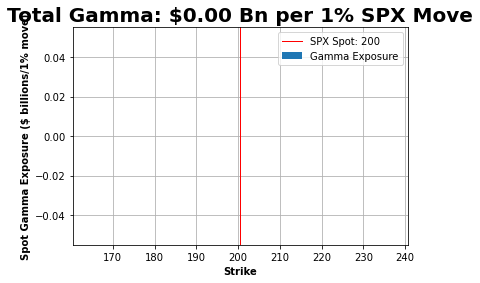

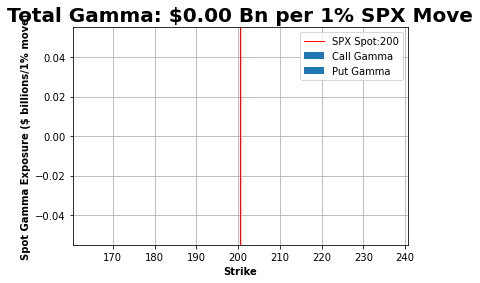

In [85]:
import pandas as pd
import numpy as np
import scipy
from scipy.stats import norm
import matplotlib.pyplot as plt
from datetime import datetime, timedelta, date

pd.options.display.float_format = '{:,.4f}'.format

# Inputs and Parameters
filename = 'tsla_quotedata.csv'

# Black-Scholes European-Options Gamma
def calcGammaEx(S, K, vol, T, r, q, optType, OI):
    if T == 0 or vol == 0:
        return 0

    dp = (np.log(S/K) + (r - q + 0.5*vol**2)*T) / (vol*np.sqrt(T))
    dm = dp - vol*np.sqrt(T) 

    if optType == 'call':
        gamma = np.exp(-q*T) * norm.pdf(dp) / (S * vol * np.sqrt(T))
        return OI * 100 * S * S * 0.01 * gamma 
    else: # Gamma is same for calls and puts. This is just to cross-check
        gamma = K * np.exp(-r*T) * norm.pdf(dm) / (S * S * vol * np.sqrt(T))
        return OI * 100 * S * S * 0.01 * gamma 

def isThirdFriday(d):
    return d.weekday() == 4 and 15 <= d.day <= 21

# This assumes the CBOE file format hasn't been edited, i.e. table beginds at line 4
optionsFile = open(filename)
optionsFileData = optionsFile.readlines()
optionsFile.close()

# Get SPX Spot
spotLine = optionsFileData[1]
spotPrice = float(spotLine.split('Last:')[1].split(',')[0])
fromStrike = 0.8 * spotPrice
toStrike = 1.2 * spotPrice

# Get Today's Date
dateLine = optionsFileData[2]
todayDate = dateLine.split('Date: ')[1].split(' ')
day1=todayDate[1].split(',')

year=int(todayDate[2])
month=todayDate[0]
day=int(day1[0])

todayDate = datetime.strptime(month,'%B')
todayDate = todayDate.replace(day=day, year=year)

# Get SPX Options Data
df = pd.read_csv(filename, sep=",", header=None, skiprows=4)
df.columns = ['ExpirationDate','Calls','CallLastSale','CallNet','CallBid','CallAsk','CallVol',
              'CallIV','CallDelta','CallGamma','CallOpenInt','StrikePrice','Puts','PutLastSale',
              'PutNet','PutBid','PutAsk','PutVol','PutIV','PutDelta','PutGamma','PutOpenInt']

df_expiration = (df['ExpirationDate'] == 'Fri Oct 21 2022')
df_expiration = df[df_expiration]
df_expiration

df_expiration['ExpirationDate'] = pd.to_datetime(df_expiration['ExpirationDate'], format='%a %b %d %Y')
df_expiration['ExpirationDate'] = df_expiration['ExpirationDate'] + timedelta(hours=16)
df_expiration['StrikePrice'] = df_expiration['StrikePrice'].astype(float)
df_expiration['CallIV'] = df_expiration['CallIV'].astype(float)
df_expiration['PutIV'] = df_expiration['PutIV'].astype(float)
df_expiration['CallGamma'] = df_expiration['CallGamma'].astype(float)
df_expiration['PutGamma'] = df_expiration['PutGamma'].astype(float)
df_expiration['CallOpenInt'] = df_expiration['CallOpenInt'].astype(float)
df_expiration['PutOpenInt'] = df_expiration['PutOpenInt'].astype(float)


# ---=== CALCULATE SPOT GAMMA ===---
# Gamma Exposure = Unit Gamma * Open Interest * Contract Size * Spot Price 
# To further convert into 'per 1% move' quantity, multiply by 1% of spotPrice
df_expiration['CallGEX'] = df_expiration['CallGamma'] * df_expiration['CallOpenInt'] * 100 * spotPrice * spotPrice * 0.01
df_expiration['PutGEX'] = df_expiration['PutGamma'] * df_expiration['PutOpenInt'] * 100 * spotPrice * spotPrice * 0.01 * -1

df_expiration['TotalGamma'] = (df_expiration.CallGEX + df_expiration.PutGEX) / 10**9
df_expirationAgg = df_expiration.groupby(['StrikePrice']).sum()
strikes = df_expirationAgg.index.values

# Chart 1: Absolute Gamma Exposure
plt.grid()
plt.bar(strikes, df_expirationAgg['TotalGamma'].to_numpy(), width=1, linewidth=0.1, edgecolor='k', label="Gamma Exposure")
plt.xlim([fromStrike, toStrike])
chartTitle = "Total Gamma: $" + str("{:.2f}".format(df_expiration['TotalGamma'].sum())) + " Bn per 1% SPX Move"
plt.title(chartTitle, fontweight="bold", fontsize=20)
plt.xlabel('Strike', fontweight="bold")
plt.ylabel('Spot Gamma Exposure ($ billions/1% move)', fontweight="bold")
plt.axvline(x=spotPrice, color='r', lw=1, label="SPX Spot: " + str("{:,.0f}".format(spotPrice)))
plt.legend()
plt.show()

# Chart 2: Absolute Gamma Exposure by Calls and Puts
plt.grid()
plt.bar(strikes, df_expirationAgg['CallGEX'].to_numpy() / 10**9, width=1, linewidth=0.1, edgecolor='k', label="Call Gamma")
plt.bar(strikes, df_expirationAgg['PutGEX'].to_numpy() / 10**9, width=1, linewidth=0.1, edgecolor='k', label="Put Gamma")
plt.xlim([fromStrike, toStrike])
chartTitle = "Total Gamma: $" + str("{:.2f}".format(df_expiration['TotalGamma'].sum())) + " Bn per 1% SPX Move"
plt.title(chartTitle, fontweight="bold", fontsize=20)
plt.xlabel('Strike', fontweight="bold")
plt.ylabel('Spot Gamma Exposure ($ billions/1% move)', fontweight="bold")
plt.axvline(x=spotPrice, color='r', lw=1, label="SPX Spot:" + str("{:,.0f}".format(spotPrice)))
plt.legend()
plt.show()


# # ---=== CALCULATE GAMMA PROFILE ===---
# levels = np.linspace(fromStrike, toStrike, 60)

# # For 0DTE options, I'm setting DTE = 1 day, otherwise they get excluded
# df_expiration['daysTillExp'] = [1/262 if (np.busday_count(todayDate.date(), x.date())) == 0 \
#                            else np.busday_count(todayDate.date(), x.date())/262 for x in df_expiration.ExpirationDate]

# nextExpiry = df_expiration['ExpirationDate'].min()

# df_expiration['IsThirdf_expirationriday'] = [isThirdf_expirationriday(x) for x in df_expiration.ExpirationDate]
# thirdf_expirationridays = df_expiration.loc[df_expiration['IsThirdf_expirationriday'] == True]
# nextMonthlyExp = thirdf_expirationridays['ExpirationDate'].min()

# totalGamma = []
# totalGammaExNext = []
# totalGammaExFri = []

# # For each spot level, calc gamma exposure at that point
# for level in levels:
#     df_expiration['callGammaEx'] = df_expiration.apply(lambda row : calcGammaEx(level, row['StrikePrice'], row['CallIV'], 
#                                                           row['daysTillExp'], 0, 0, "call", row['CallOpenInt']), axis = 1)

#     df_expiration['putGammaEx'] = df_expiration.apply(lambda row : calcGammaEx(level, row['StrikePrice'], row['PutIV'], 
#                                                          row['daysTillExp'], 0, 0, "put", row['PutOpenInt']), axis = 1)    

#     totalGamma.append(df_expiration['callGammaEx'].sum() - df_expiration['putGammaEx'].sum())

#     exNxt = df_expiration.loc[df_expiration['ExpirationDate'] != nextExpiry]
#     totalGammaExNext.append(exNxt['callGammaEx'].sum() - exNxt['putGammaEx'].sum())

#     exFri = df_expiration.loc[df_expiration['ExpirationDate'] != nextMonthlyExp]
#     totalGammaExFri.append(exFri['callGammaEx'].sum() - exFri['putGammaEx'].sum())

# totalGamma = np.array(totalGamma) / 10**9
# totalGammaExNext = np.array(totalGammaExNext) / 10**9
# totalGammaExFri = np.array(totalGammaExFri) / 10**9

# # Find Gamma Flip Point
# zeroCrossIdx = np.where(np.diff(np.sign(totalGamma)))[0]

# negGamma = totalGamma[zeroCrossIdx]
# posGamma = totalGamma[zeroCrossIdx+1]
# negStrike = levels[zeroCrossIdx]
# posStrike = levels[zeroCrossIdx+1]

# # Writing and sharing this code is only possible with your support! 
# # If you find it useful, consider supporting us at perfiliev.com/support :)
# zeroGamma = posStrike - ((posStrike - negStrike) * posGamma/(posGamma-negGamma))
# zeroGamma = zeroGamma[0]

# # Chart 3: Gamma Exposure Profile
# fig, ax = plt.subplots(figsize=(20,10))
# plt.grid()
# plt.plot(levels, totalGamma, label="All Expiries")
# plt.plot(levels, totalGammaExNext, label="Ex-Next Expiry")
# plt.plot(levels, totalGammaExFri, label="Ex-Next Monthly Expiry")
# chartTitle = "Gamma Exposure Profile, SPX, " + todayDate.strftime('%d %b %Y')
# plt.title(chartTitle, fontweight="bold", fontsize=20)
# plt.xlabel('Index Price', fontweight="bold")
# plt.ylabel('Gamma Exposure ($ billions/1% move)', fontweight="bold")
# plt.axvline(x=spotPrice, color='r', lw=1, label="SPX Spot: " + str("{:,.0f}".format(spotPrice)))
# plt.axvline(x=zeroGamma, color='g', lw=1, label="Gamma Flip: " + str("{:,.0f}".format(zeroGamma)))
# plt.axhline(y=0, color='grey', lw=1)
# plt.xlim([fromStrike, toStrike])
# trans = ax.get_xaxis_transform()
# plt.fill_between([fromStrike, zeroGamma], min(totalGamma), max(totalGamma), facecolor='red', alpha=0.1, transform=trans)
# plt.fill_between([zeroGamma, toStrike], min(totalGamma), max(totalGamma), facecolor='green', alpha=0.1, transform=trans)
# plt.legend()
# plt.show()